# Model usage tutorial

Tutorial disclaimer: no good/bad sample selection was done in choosing demo images, one of each m, p and i was chosen

In [76]:
import torch
from torchvision import transforms
import glob
import matplotlib.pyplot as plt
from PIL import Image

torch.manual_seed(2)

In [77]:
# load pretrained models
uplow_model = torch.load('./upperlower.pt')
mpi_model = torch.load('./MPI.pt')
index_model_123 = torch.load('./123.pt')
index_model_1234 = torch.load('./1234.pt')
index_model_1234

Sequential(
  (0): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1):

In [78]:
# Class to index mappings
class_to_idx = {
    '123': {'1': 0, '2': 1, '3': 2},
    'mpi': {'I': 0, 'M': 1, 'P': 2},
    '1234': {'1': 0, '2': 1, '3': 2, '4': 3},
    'upperlower': {'low': 0, 'up': 1}
}

In [79]:
# Define transformation: grayscale, resize & normalize (three duplicate grayscale channels to match alexnet expected input shape)
preprocess = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.2, 0.2, 0.2])
])

In [80]:
# Inference helper functions
def image_to_batch(image):
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Create a batch of size 1 from image to match required input dimension
    return input_batch

def infer(model, input_batch):
    with torch.no_grad():
        output = model(input_batch)
        _, prediction = torch.max(output, 1)
        confidence = output.max()
    return prediction, confidence

def infer_uplow(input_batch):
    prediction_id, confidence = infer(uplow_model, input_batch)
    predicted = next((k for k, v in class_to_idx['upperlower'].items() if v == prediction_id), None)
    return predicted, confidence

def infer_mpi(input_batch):
    prediction_id, confidence = infer(mpi_model, input_batch)
    predicted = next((k for k, v in class_to_idx['mpi'].items() if v == prediction_id), None)
    return predicted, confidence

def infer_123(input_batch):
    prediction_id, confidence = infer(index_model_123, input_batch)
    predicted = next((k for k, v in class_to_idx['123'].items() if v == prediction_id), None)
    return predicted, confidence

def infer_1234(input_batch):
    prediction_id, confidence = infer(index_model_1234, input_batch)
    predicted = next((k for k, v in class_to_idx['1234'].items() if v == prediction_id), None)
    return predicted, confidence

In [81]:
# load images
demo_images = glob.glob('./demo_images/*.png')

In [82]:
images = []
dental_markings = []
confidence_scores = []

for image in demo_images:
    print(image)
    image = Image.open(image).convert("RGB")  # Ensure the image is RGB

    uplow, uplow_confidence = infer_uplow(image_to_batch(image))
    print(f'Predicted {uplow} with confidence {uplow_confidence:.3f}')
    
    mpi, mpi_confidence = infer_mpi(image_to_batch(image))
    print(f'Predicted {mpi} with confidence {mpi_confidence:.3f}')

    if mpi == 'P':
        index, index_confidence = infer_1234(image_to_batch(image)) 
    else:
        # M and I
        index, index_confidence = infer_123(image_to_batch(image))
    print(f'Predicted {index} with confidence {index_confidence:.3f}')

    letter = mpi.upper() if uplow == 'up' else mpi.lower()
    marking = f'{letter}{index}'
    print(f'Dental marking: {marking}')
    final_confidence = min(uplow_confidence, mpi_confidence, index_confidence)
    print(f'Confidence: {final_confidence:.4f}')

    dental_markings.append(marking)
    images.append(image)
    confidence_scores.append(final_confidence)
    print()


./demo_images/56.png
Predicted up with confidence 0.943
Predicted P with confidence 1.000
Predicted 4 with confidence 1.000
Dental marking: P4
Confidence: 0.9432

./demo_images/7.png


Predicted up with confidence 0.999
Predicted I with confidence 1.000
Predicted 2 with confidence 0.996
Dental marking: I2
Confidence: 0.9959

./demo_images/14.png
Predicted low with confidence 0.992
Predicted M with confidence 1.000
Predicted 2 with confidence 0.985
Dental marking: m2
Confidence: 0.9854



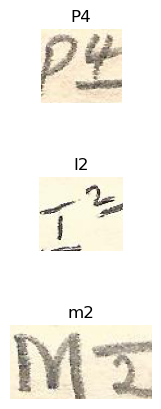

In [83]:
fig, ax = plt.subplots(3,1)
plt.subplots_adjust(hspace=1.0)
for i in range(len(images)):
    ax[i].imshow(images[i])
    ax[i].set_title(dental_markings[i])
    ax[i].axis('off')